In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns 
from nilearn import plotting

# functions
from utils import PROJECT_PATH, OUT_PATH, FREQ_BAND
from utils import preproc, TFRmEvents, ExcludSubj

In [2]:
subj_included = [file.replace('sub-', '') for file in os.listdir(PROJECT_PATH + '/data/BIDS') if file[:4] == 'sub-']
failled =['COG023', 'LL10', 'CP41', 'LL23', 'CP40', 'COG022', 'LL30', 'LL15']

for s in failled :
    subj_included.remove(s)

subj_included = ExcludSubj(subj_included)

### PREPROC

In [3]:
for subj in subj_included : 
    path_to_save = OUT_PATH + '/Data' 
    if not os.path.exists(path_to_save + f'/{subj}_TFRtrials.p'):
        print(subj)
        preproc(subj, trials=True, save_epoch=True, compute_TFR=True)

In [4]:
for subj in ['BJH029', 'DA037', 'BJH058']:
    file = f'{OUT_PATH}/Data/{subj}_epochs.p'
    with open(file, "rb") as f:
        epochs = pickle.load(f)
        print(subj)
        print(epochs.shape)

BJH029
(48, 133, 700)
DA037
(48, 36, 700)
BJH058
(48, 166, 700)


## Correct the delay

In [3]:
from utils import read_raw_bids, get_bads, BIDSPath, TASK
subj = subj_included[0]
info = {}
if not os.path.exists(OUT_PATH) : 
    os.makedirs(OUT_PATH)

bids_root = os.path.join(PROJECT_PATH,'data/BIDS/')
bids_path = BIDSPath(subject=subj,task=TASK,root=bids_root)
elec_path = os.path.join(PROJECT_PATH, 'misc/electrodes/', subj + '_electrodes.csv')

bads_path = os.path.join(PROJECT_PATH, 'misc/bad_channels/', subj + '_bad_channels.csv')
bad_channels, white_channels, _ = get_bads(subj, bads_path, elec_path)

raw = read_raw_bids(bids_path)  
raw.pick_types(seeg=True, ecog = True)

onsets = []
decription = []

for ano in raw.annotations : 
    if 'bach' in ano['description'] : 
        onsets.append(ano['onset'])
        decription.append(ano['description'])
if min(onsets) -2 <0 : 
    tmin_  = min(onsets)
else : 
    tmin_ = min(onsets) -2
raw.crop(tmin = tmin_ , tmax = max(onsets) + 50)
raw.load_data() 

Extracting EDF parameters from /users/barbara/Desktop/MINDLAB2021_MEG-TempSeqAges/scratch/learning_bach_iEEG/data/BIDS/sub-LL08/ieeg/sub-LL08_task-MusicMemory_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ../MINDLAB2021_MEG-TempSeqAges/scratch/learning_bach_iEEG/data/BIDS/sub-LL08/ieeg/sub-LL08_task-MusicMemory_events.tsv.
Reading channel info from ../MINDLAB2021_MEG-TempSeqAges/scratch/learning_bach_iEEG/data/BIDS/sub-LL08/ieeg/sub-LL08_task-MusicMemory_channels.tsv.
Reading electrode coords from ../MINDLAB2021_MEG-TempSeqAges/scratch/learning_bach_iEEG/data/BIDS/sub-LL08/ieeg/sub-LL08_space-fsaverage_electrodes.tsv.


/tmp/ipykernel_12302/3660999166.py:14: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = read_raw_bids(bids_path)
/tmp/ipykernel_12302/3660999166.py:14: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = read_raw_bids(bids_path)
/tmp/ipykernel_12302/3660999166.py:14: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['EKG', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C121', 'C122', 'C123', 'C124', 'C125', 'C126', 'C127', 'C128', 'DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'TRIG', 'OSAT', 'PR', 'Pleth']
  raw = read_raw_bids(bids_path)
/tmp/ipykernel_12302/3660999166.py:14: RuntimeWarning: Not setting positions of 58 misc channels found in monta

Not fully anonymizing info - keeping his_id, sex, and hand info
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 394411  =      0.000 ...   385.167 secs...


<RawEDF | sub-LL08_task-MusicMemory_ieeg.edf, 90 x 394412 (385.2 s), ~270.9 MiB, data loaded>

In [11]:
np.unique(raw.annotations.description)

array(['learning_bach_10', 'learning_bach_20', 'learning_bach_48',
       'learning_bach_49', 'learning_bach_50', 'learning_bach_990'],
      dtype='<U17')

## VIZ FOR INTRO

In [5]:
# good subj 
subj = 'BJH026'

In [6]:
# Get the coords -- MONTAGE
coord = pd.read_csv(f'{OUT_PATH}/Data/{subj}_coords.csv').rename(columns = {'Unnamed: 0' : 'channels'}).drop(columns = 'subj')
coord_array = coord.set_index('channels').values 

In [7]:
# Get the electrods file
elect = pd.read_csv(PROJECT_PATH + f'/misc/electrodes/{subj}_electrodes.csv').set_index('electrode')
coord['area1'] = coord['channels'].apply(lambda x : elect.loc[x.split('_')[0], 'label'])
coord['area2'] = coord['channels'].apply(lambda x : elect.loc[x.split('_')[0], 'label'])
array_map = {area: num+1 for num, area in enumerate(np.unique(coord['area1'].values))}
lab = coord['area1'].map(array_map).values

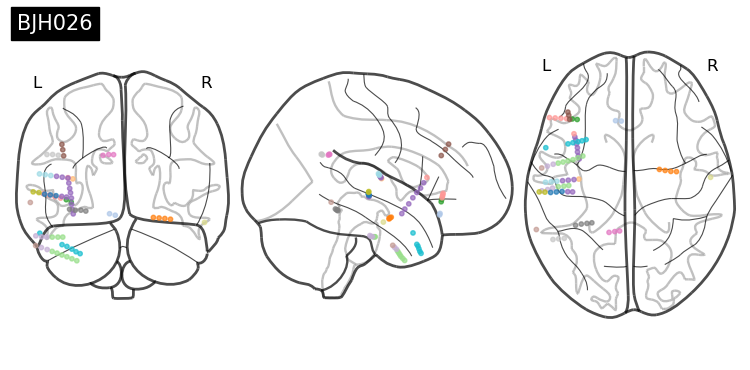

In [8]:

plotting.plot_markers(node_coords = coord_array,  node_size=10, node_values=lab, node_cmap='tab20', colorbar=False, title=subj)

### 1. BroadBand

In [9]:
# VIZ TFR
file = f'{OUT_PATH}/Data/{subj}_epochs.p'
with open(file, "rb") as f:
    epochs = pickle.load(f)

# get the info 
info_file = f'{OUT_PATH}/Data/{subj}_info.json'
with open(info_file) as f:
    info = json.load(f)
    time = info['time_epoch']
    channels = info['chnames']
    events_index = np.array([int(i) for i in info['event_id']])

# compute the mean accorss trials within the same condi
index_condi1 = np.where(events_index == 1)[0] # 'old/correct'
index_condi2 = np.where(events_index == 2)[0] # 'new/correct'

# compute the mean accross the condi fit the PCA get compo + exp va
data_mean = np.zeros((2,epochs.shape[1], epochs.shape[2]))
data_mean[0, :,:] = epochs[index_condi1, :,:].mean(0)
data_mean[1, :,:] = epochs[index_condi2, :,:].mean(0)

Text(-0.3, -0.7, 'New/correct')

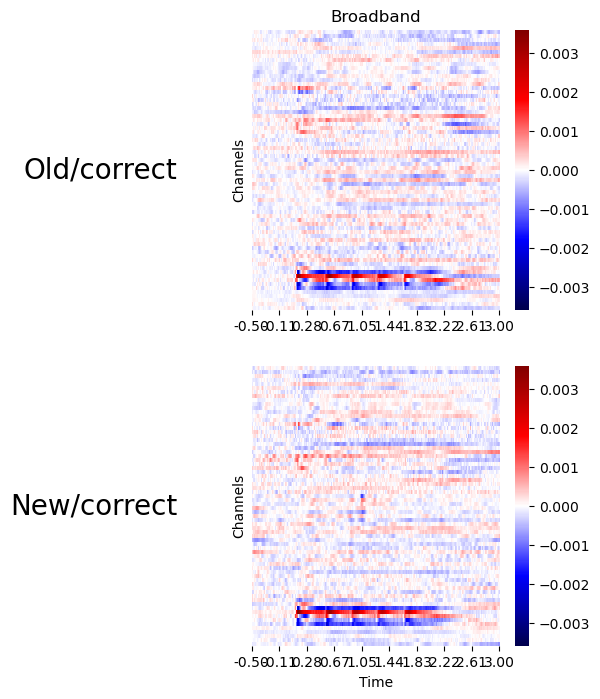

In [10]:
# VIZ BROAD BAND 1 SUBJ
vmax = np.abs(data_mean).max()
vmin = -vmax

fig, ax= plt.subplots(2, 1, figsize=(4, 8))
sns.heatmap(data_mean[0, :, :], ax = ax[0], cmap='seismic', xticklabels=150,yticklabels=False, center=0,vmin=vmin,vmax=vmax)
sns.heatmap(data_mean[1, :, :], ax = ax[1], cmap='seismic', xticklabels=150, yticklabels=False, center=0,vmin=vmin,vmax=vmax)
ax[0].set_title(f'Broadband', fontsize=12)

for i in range(2)  :
    ax[i].set_xticks(ticks=np.linspace(0, len(time)-1, 10),labels=[f"{t:.2f}" for t in np.linspace(time[0], time[-1], 10)])
    ax[i].set_ylabel('Channels', fontsize=10)
ax[1].set_xlabel('Time', fontsize=10)

ax[0].text(-0.3, 0.5, 'Old/correct' ,rotation=0, va='center', ha='right', fontsize=20,transform=ax[0].transAxes)
ax[1].text(-0.3, -0.7, 'New/correct' ,rotation=0, va='center', ha='right', fontsize=20,transform=ax[0].transAxes)


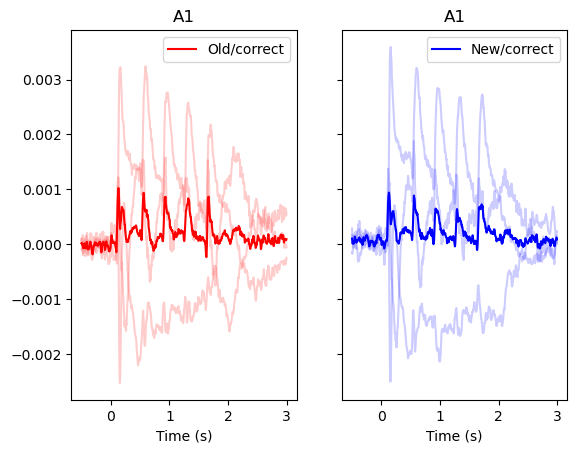

In [11]:
# focus on A1 electrods
area_to_plot = 'A1'

fig, ax= plt.subplots(1, 2, sharex=True, sharey=True)
ids = list(coord[coord['area2'] == area_to_plot].index)
ids.extend(list(coord[coord['area1'] == area_to_plot].index))
ids = np.unique(ids)
color = ['red', 'blue']
labels = ['Old/correct', 'New/correct']
if len(ids) != 0 :
    for i, a in enumerate(ax) :
        for ch in ids : 
            a.plot(time, data_mean[i,ch, :], color=color[i], alpha = 0.2)

        a.plot(time, data_mean[i,ids, : ].mean(0), color=color[i], label =labels[i])
        a.set_title(area_to_plot)

        a.legend()
        a.set_xlabel('Time (s)')


### 2. TFRm

In [12]:
TFRm = TFRmEvents(subj)

info_file = f'{OUT_PATH}/Data/{subj}_info.json'
with open(info_file) as f:
    info = json.load(f)
    time = info['time_tfr']

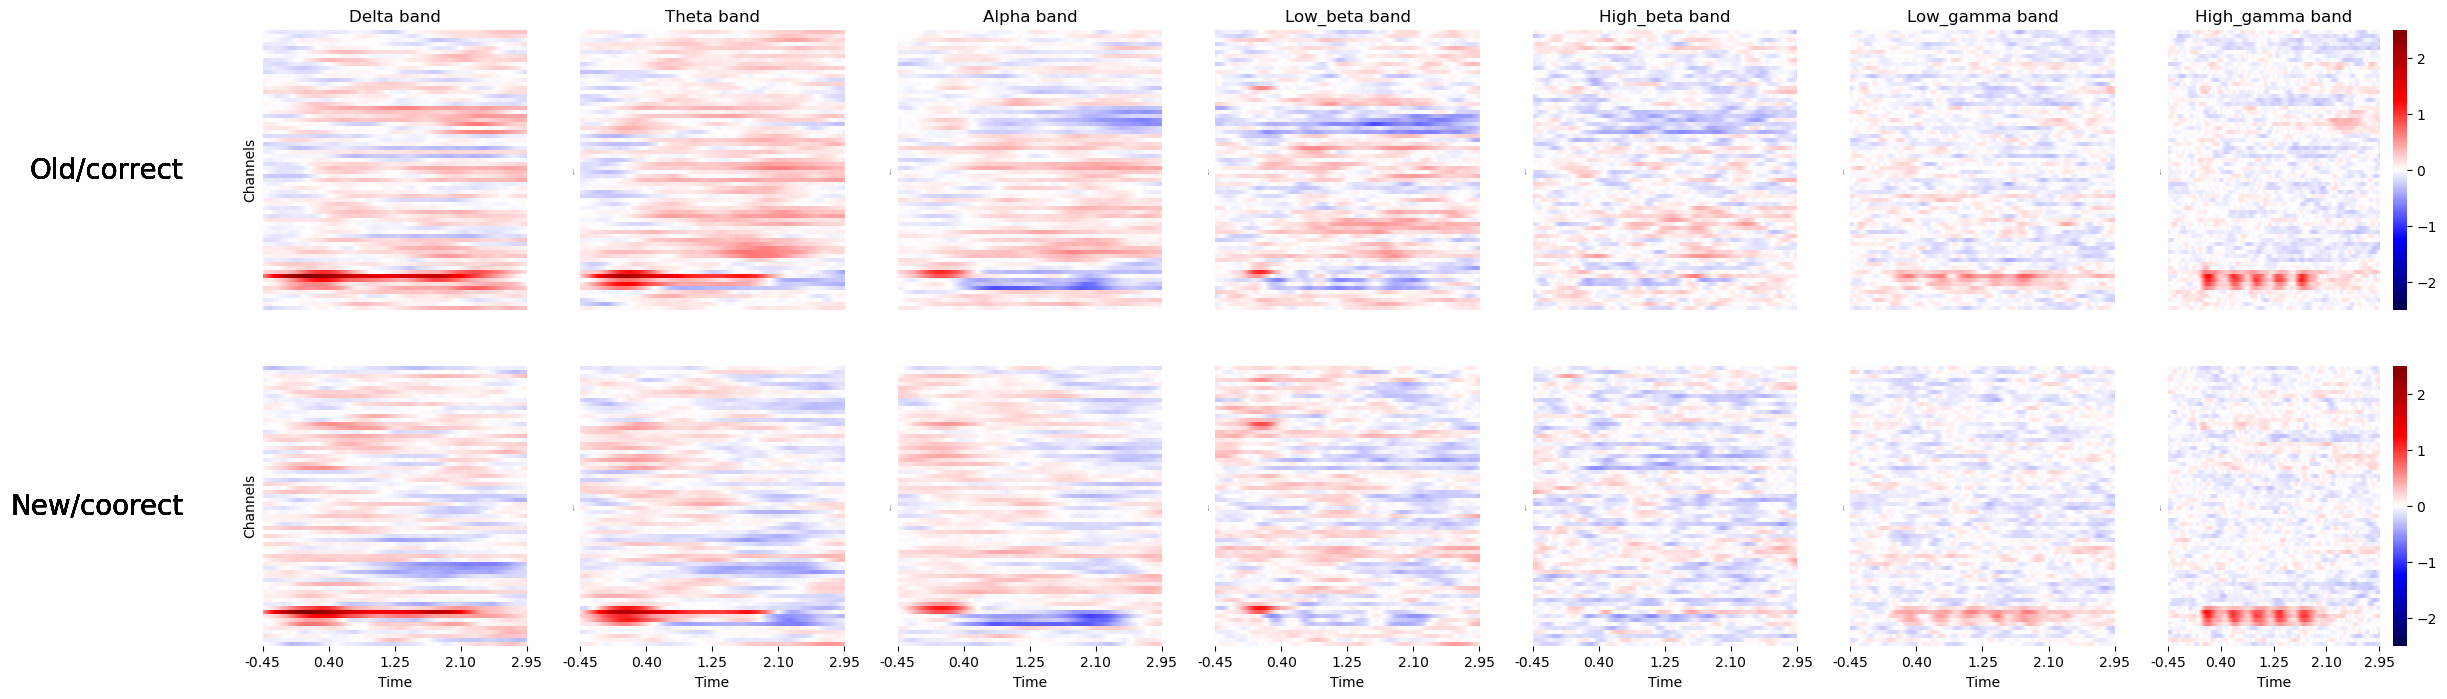

In [13]:
vmax = np.abs(TFRm).max()
vmin = -vmax

fig, ax= plt.subplots(2, len(FREQ_BAND), figsize=(4*len(FREQ_BAND), 8))
for freq_i, freq in enumerate(FREQ_BAND) : 
    sns.heatmap(TFRm[0, :, freq_i, :], ax = ax[0][freq_i], cmap='seismic', cbar=freq_i==len(FREQ_BAND)-1, xticklabels=False,yticklabels=False, center=0,vmin=vmin,vmax=vmax)
    sns.heatmap(TFRm[1, :, freq_i, :], ax = ax[1][freq_i], cmap='seismic', cbar=freq_i==len(FREQ_BAND)-1, xticklabels=200, yticklabels=False, center=0,vmin=vmin,vmax=vmax,)
    ax[0][freq_i].set_title(f'{freq.capitalize()} band', fontsize=12)
    ax[1][freq_i].set_xticks(ticks=np.linspace(0, len(time)-1, 5),labels=[f"{t:.2f}" for t in np.linspace(time[0], time[-1], 5)])

    ax[1][freq_i].set_xlabel('Time', fontsize=10)
    ax[0][freq_i].set_ylabel('Channels', fontsize=10 if freq_i==0 else 0)
    ax[1][freq_i].set_ylabel('Channels', fontsize=10 if freq_i==0 else 0)

    ax[0][0].text(
                -0.3, 0.5, 'Old/correct',
                rotation=0, va='center', ha='right', fontsize=20,
                transform=ax[0][0].transAxes
            )
    
    ax[1][0].text(
                -0.3, 0.5, 'New/coorect',
                rotation=0, va='center', ha='right', fontsize=20,
                transform=ax[1][0].transAxes
            )



/tmp/ipykernel_23417/3426869420.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][-1].legend()


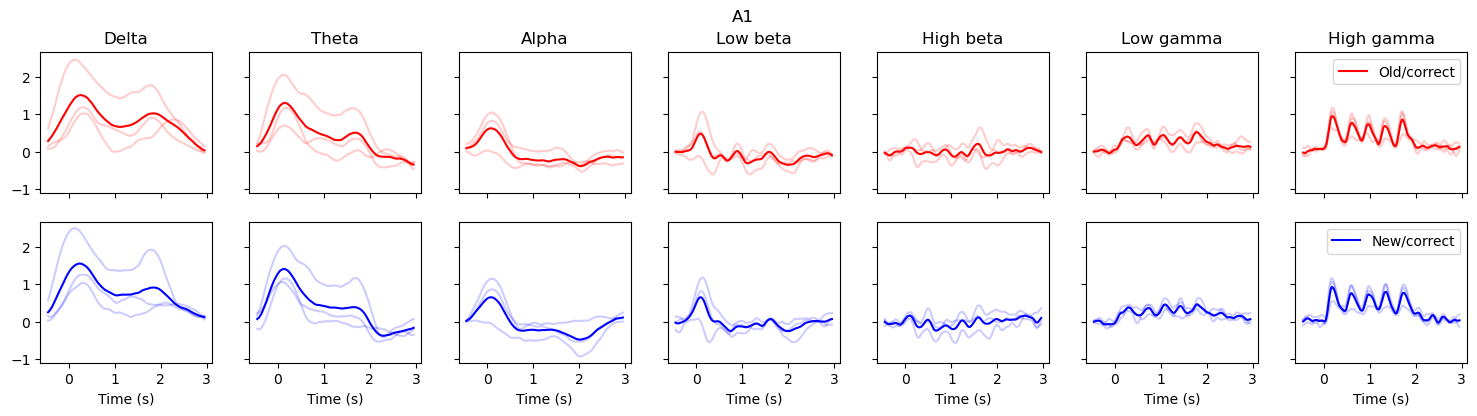

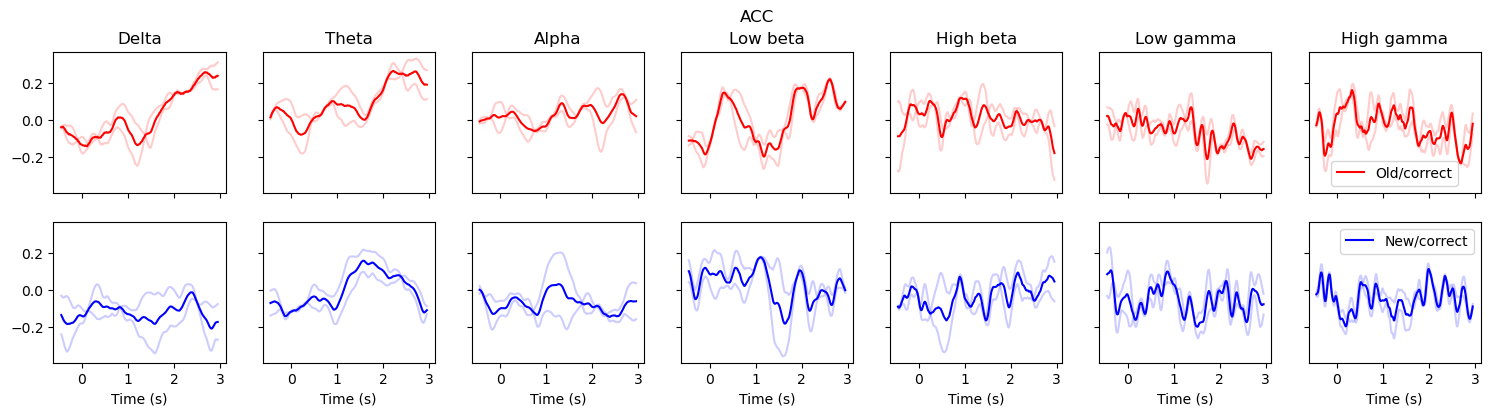

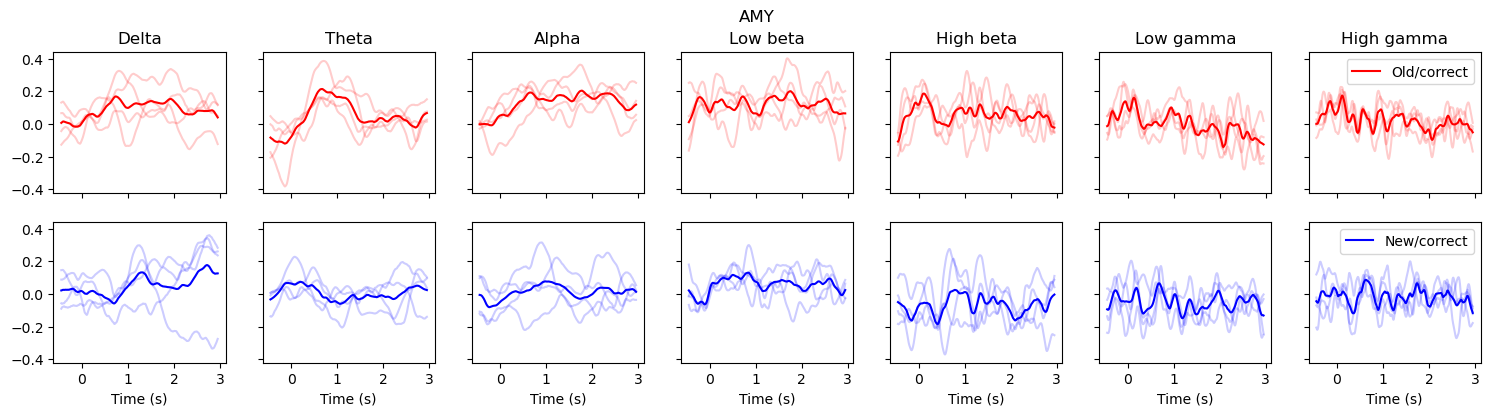

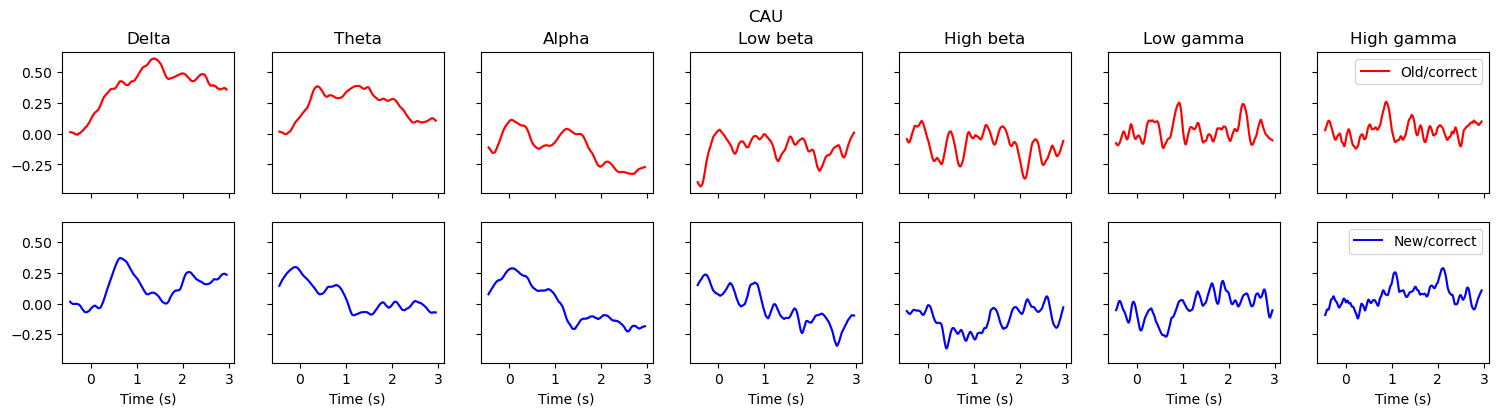

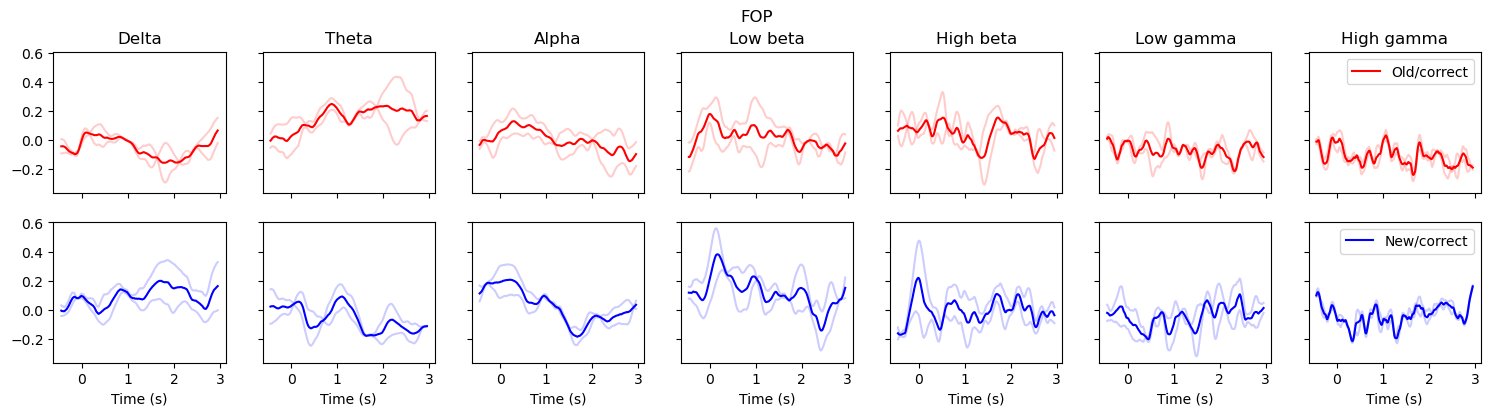

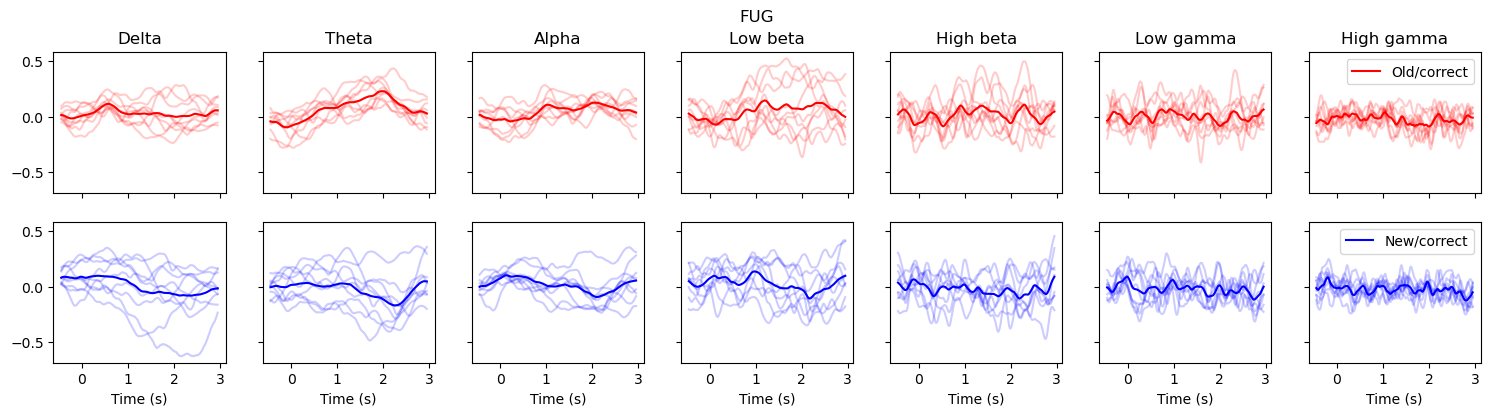

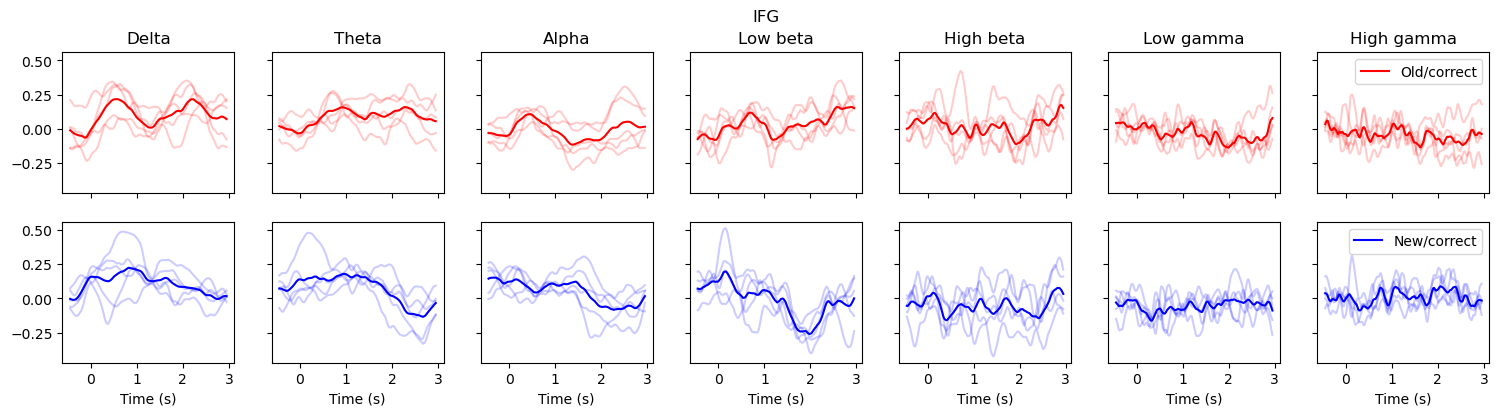

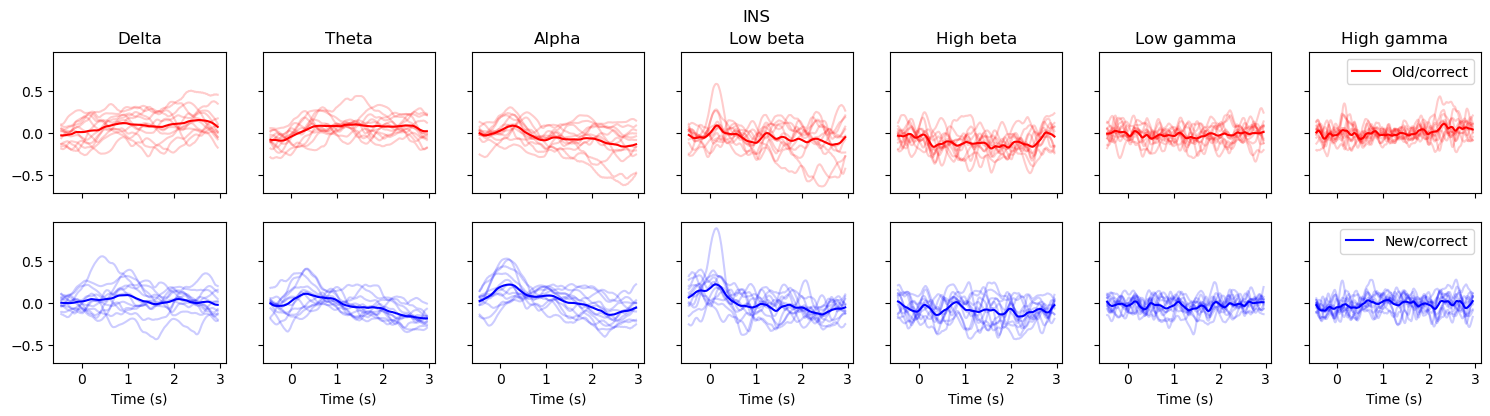

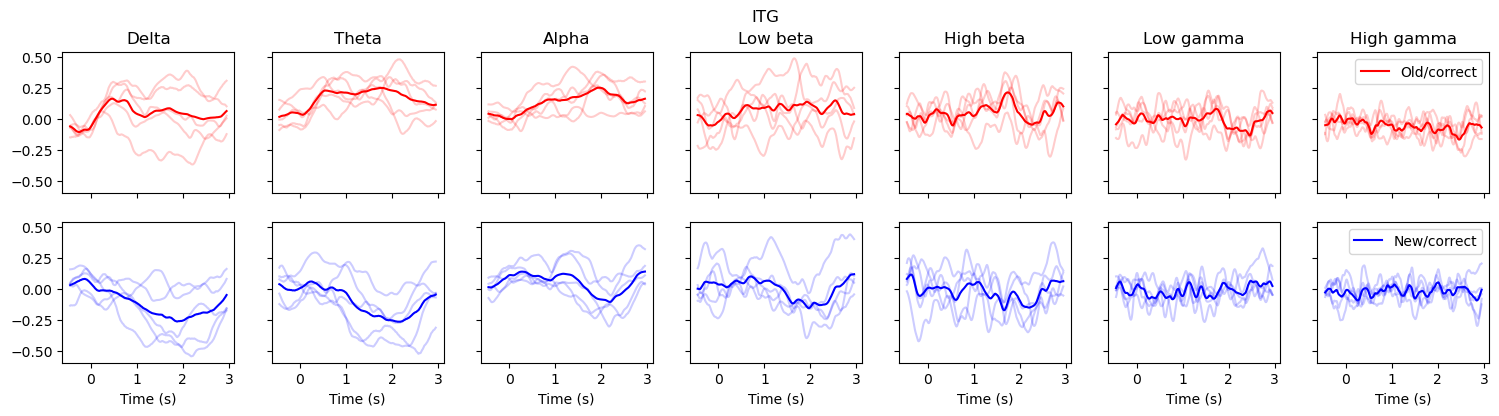

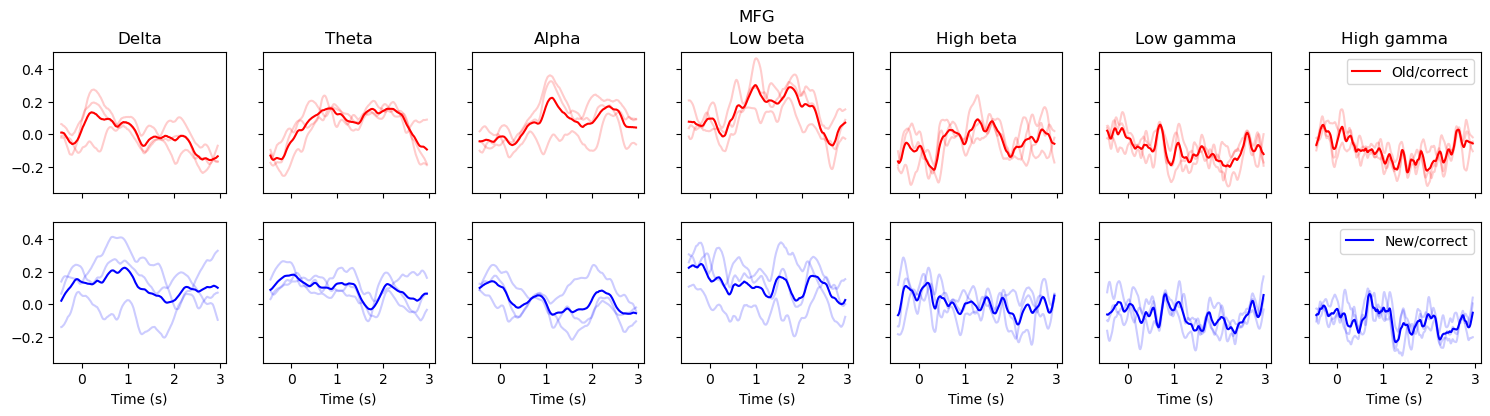

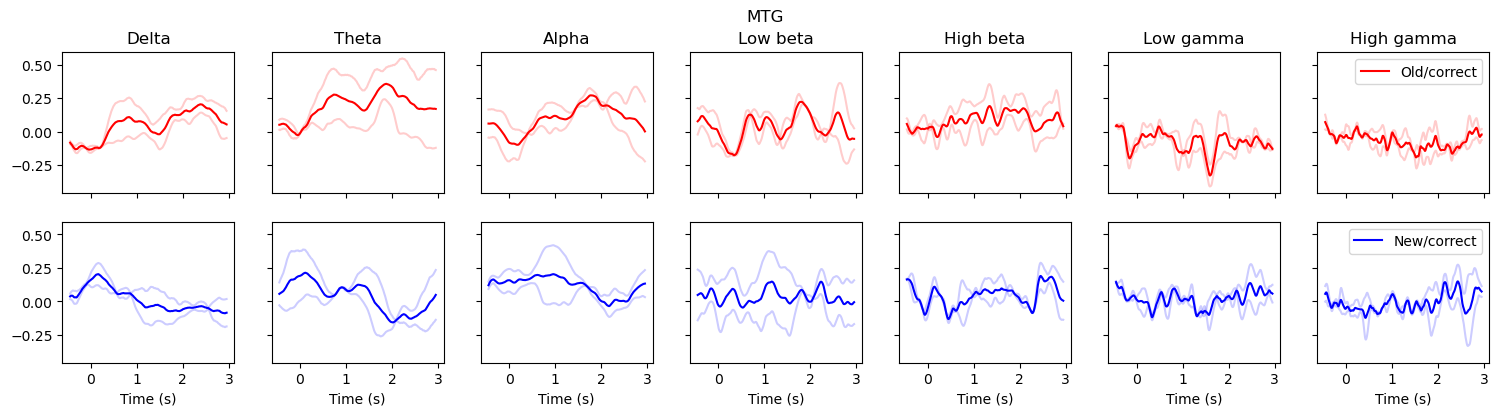

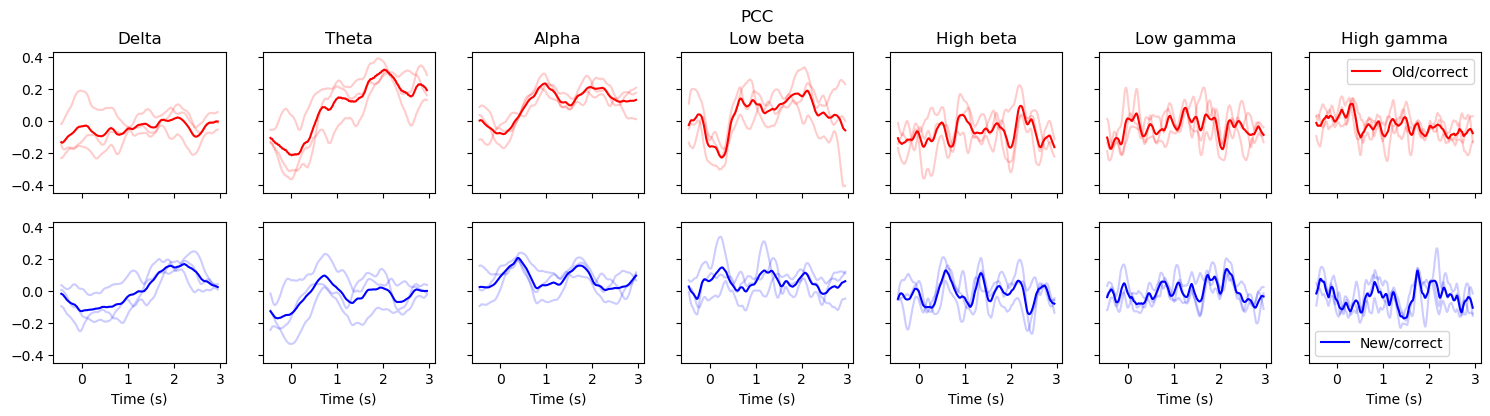

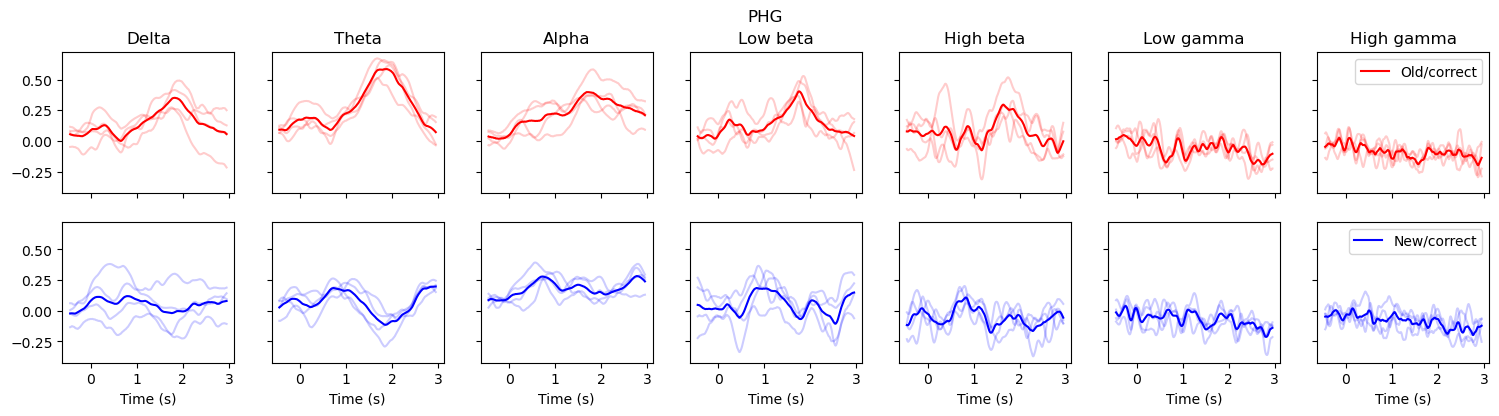

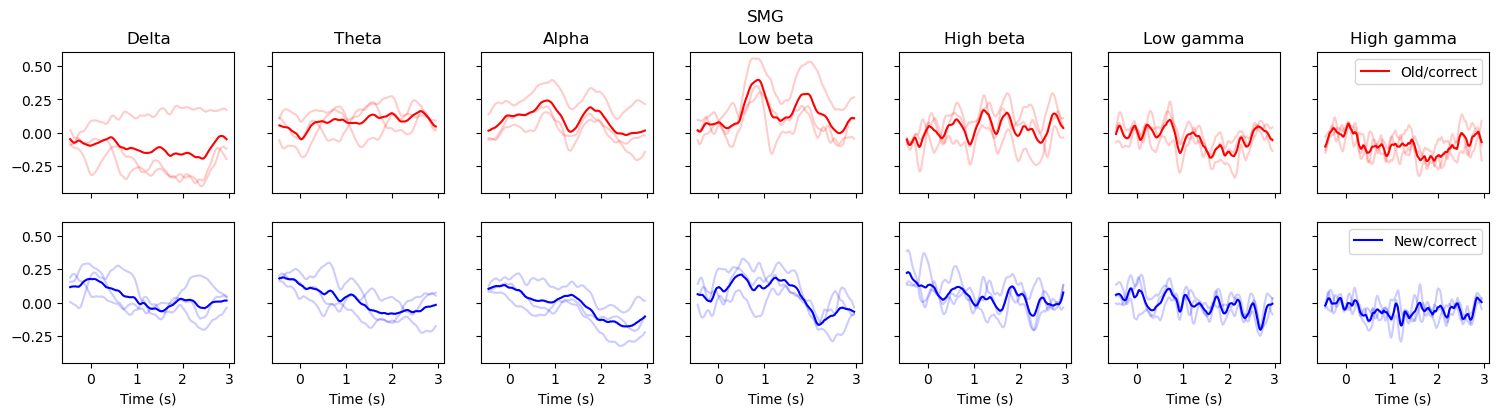

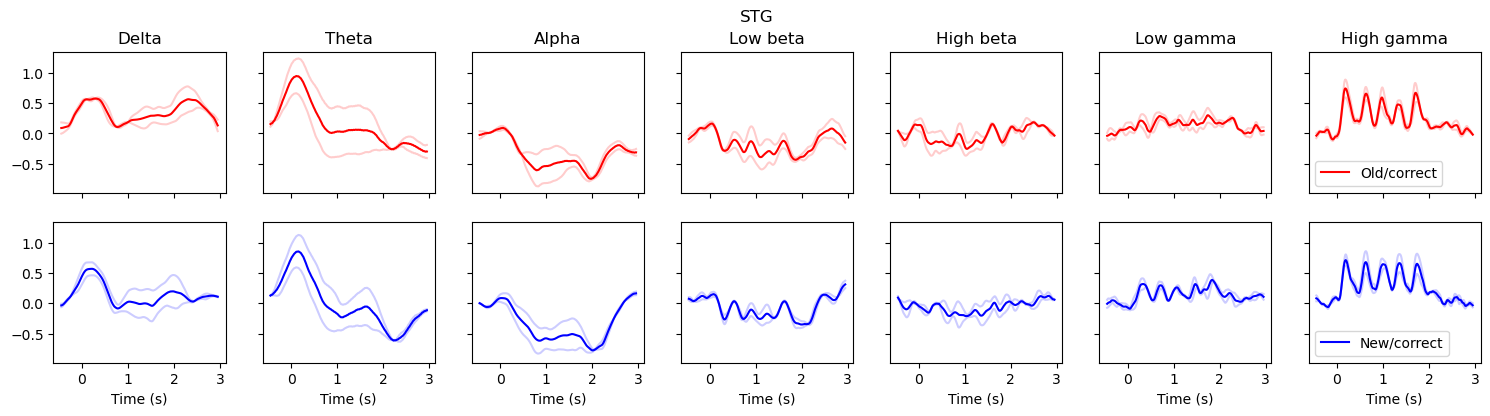

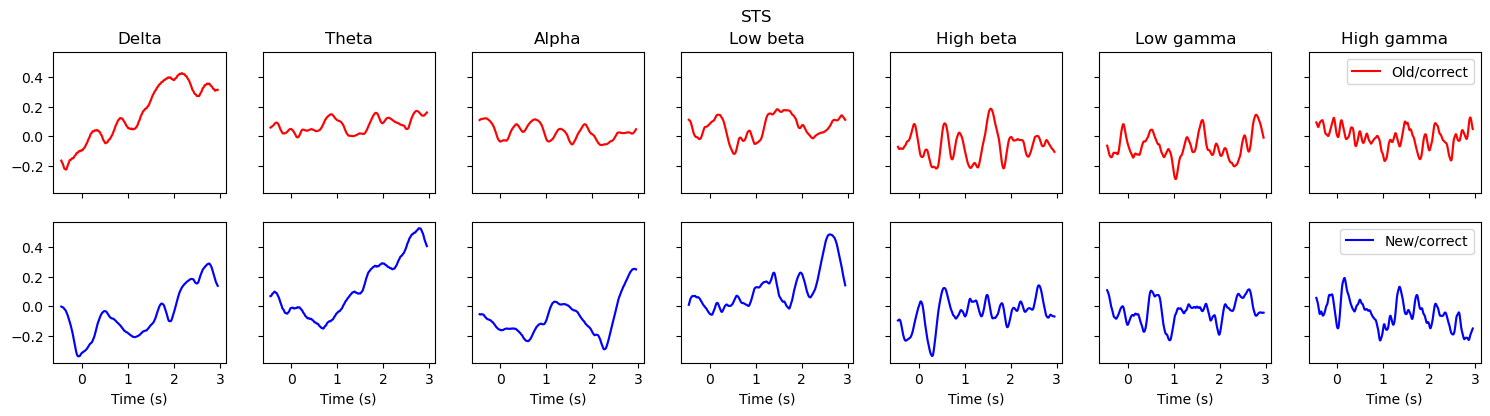

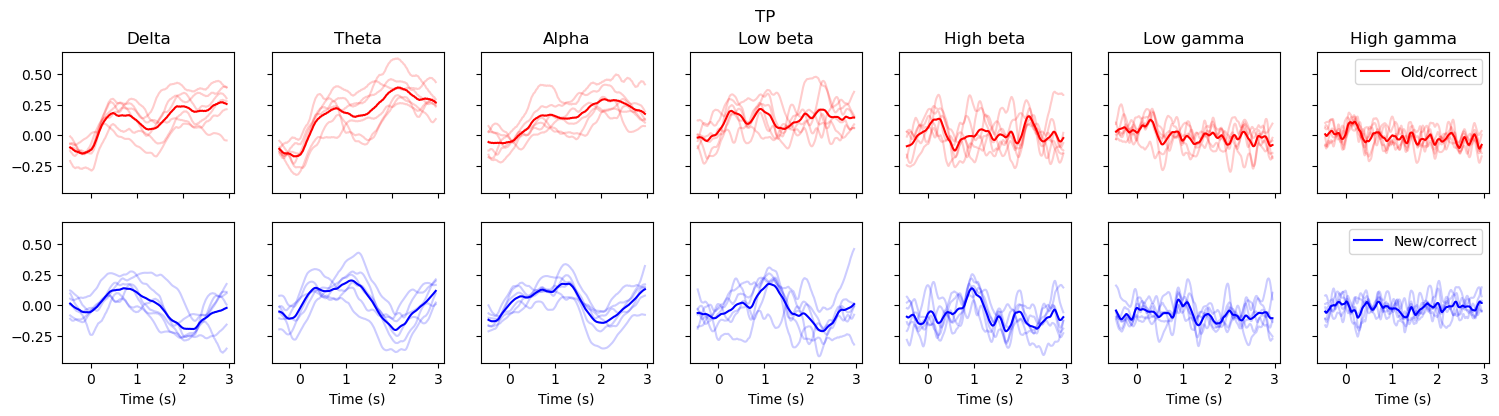

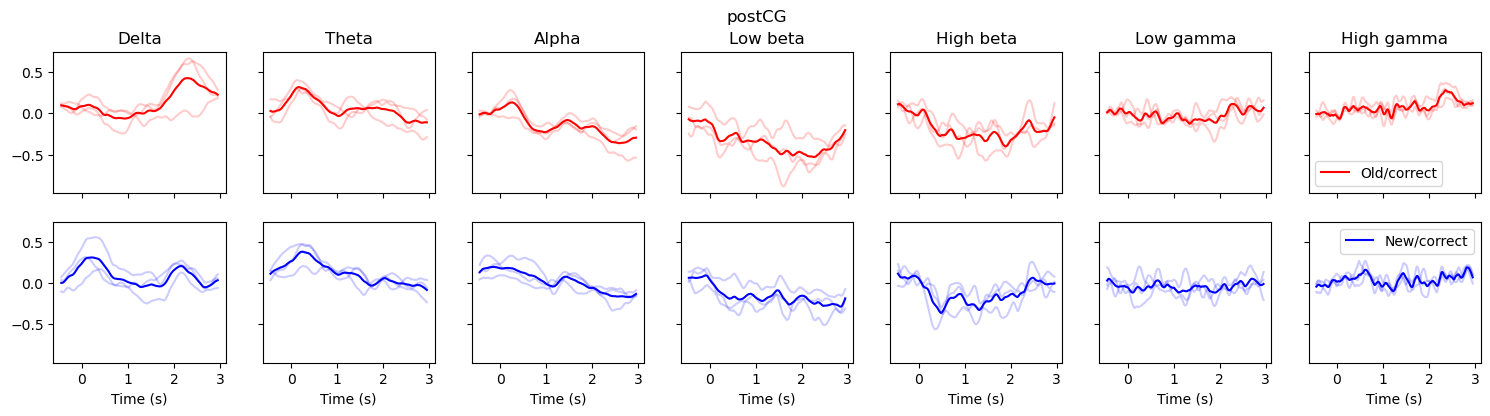

In [14]:
area_to_plot = 'A1'

for area_to_plot in np.unique(coord['area1']) : 
    fig, ax= plt.subplots(2,len(FREQ_BAND), sharex=True, sharey=True, figsize = (15, 4))
    fig.suptitle(area_to_plot)
    fig.tight_layout()

    ids = list(coord[coord['area2'] == area_to_plot].index)
    ids.extend(list(coord[coord['area1'] == area_to_plot].index))
    ids = np.unique(ids)
    color = ['red', 'blue']
    labels = ['Old/correct', 'New/correct']
    if len(ids) != 0 :
        for i_freq, band in enumerate(FREQ_BAND): 
            for i in range(2) :
                for ch in ids : 
                    ax[i][i_freq].plot(time, TFRm[i,ch, i_freq, :], color=color[i], alpha = 0.2) # gamma high

                ax[i][i_freq].plot(time, TFRm[i,ids, i_freq, : ].mean(0), color=color[i], label =labels[i])
                ax[i][-1].legend()
            ax[0][i_freq].set_title(band.capitalize().replace('_', ' '))
            ax[1][i_freq].set_xlabel('Time (s)')

In [15]:
## PLOT FOR GEMMA 
regions = {'FUG': ['FUG']}

# for topo 
coords = []
signals = []

# selected subj 
subj_selected = ['BJH052', 'BJH029', 'BJH042', 'BJH056', 'OS63']
ch_id, TFRm_dict = GetRawROIs(region ='FUG', regions= regions , out_path = f'{OUT_PATH}/subjPCA/Raw')
TFRm_select = {s:t for s, t in TFRm_dict.items() if s in subj_selected }

fig, ax = plt.subplots(1, len(subj_selected), figsize = (20, 5), sharey=True)
fig.suptitle('High Gamma - FUG iEEG channels', size = 20)
fig.tight_layout()

for i, (subj, TFRm) in enumerate(TFRm_select.items()) :  
    with open(f'{tfr_path}/{subj}_info.json') as json_data:
        d = json.load(json_data)
        time = d['time']
        json_data.close()
    
    # get coords
    
    for i_channels, channels in enumerate(ch_id[subj]) : 
        ax[i].plot(time, TFRm[0,channels,6, :].T, color=(0.68, 0.85, 0.90))
    
    for i_channels, channels in enumerate(ch_id[subj]) : 
        ax[i].plot(time, TFRm[1,channels,6, :].T, color=(1.0, 0.89, 0.88)) 
    
    ax[i].plot(time, TFRm[0,ch_id[subj],6, :].mean(0).T, color=plt.cm.Blues(0.7))
    ax[i].set_title(FREQ_BAND[6].replace('_', ' '))
    ax[i].set_title(subj, y=1)

    ax[i].plot(time, TFRm[1,ch_id[subj],6, :].mean(0).T, color=plt.cm.Reds(0.7))
    ax[i].set_title(FREQ_BAND[6].replace('_', ' '))
    ax[i].set_title(subj, y=1)
    ax[i].set_xlabel('Time (s)')

    if i == 0 :
        ax[i].set_ylabel('Normalized signal recording')

    if i == int(len(subj_selected)/2) : 
        line_handles, line_labels = ax[i].get_legend_handles_labels()

        cmap_patches = [mpatches.Patch(color=plt.cm.Blues(0.7), label='Old / Correct mean'), 
                        mpatches.Patch(color=plt.cm.Reds(0.7), label='New / Correct mean')]
        
        handles = line_handles + cmap_patches
        labels = line_labels + [p.get_label() for p in cmap_patches]

        ax[i].legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5, -0.4))

#fig.savefig("output.pdf", format="pdf", bbox_inches="tight")


NameError: name 'GetRawROIs' is not defined